## Business Analytics in SQL

In this notebook, I will be solving a series of business questions using SQLite in Python and the well-known [Chinook database](https://github.com/lerocha/chinook-database), which is data model representing a digital media store.

In [1]:
# import relevant packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt 
% matplotlib inline

### Creating Functions to Use in Our Analysis
Because we will be running multiple SQL queries in Python, it will help to create a function that simplifies the process. The context manager in the function will remove the need for us to manually open and close the connection to the database, as well as prevent us from accidentally changing the database should we run into a query error. This will be the **run_query()** function.

In [2]:
# create function with a context manager to run queries
# function returns dataframe version of the query output
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

It's also useful to have a function that runs SQL queries that don't return tables. We will use this when we want to create views. This will be the **run_command()** function.

In [3]:
# create function that executes SQL commands in the sqlite module
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None # tells SQLite to autocommit any changes
        conn.execute(c)

The third function is useful for returning a list of all of the tables and views in our database for reference, especially as they change throughout our analysis. This will be the **show_tables()** function

In [4]:
# create function that returns all tables in views in the database
def show_tables():
    return run_query('''
                      SELECT
                          name,
                          type
                      FROM sqlite_master
                      WHERE type IN ("table", "view")
                    ''')

Now let's see what tables and views are currently in the database using our functions:

In [5]:
# run show_tables()
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Selecting Albums to Purchase
The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four:
1. Artist: Regal, Genre: Hip-Hop
2. Artist: Red Tone, Genre: Punk
3. Artist: Meteor and the Girls, Genre: Pop
4. Artist: Slim Jim Bites, Genre: Blues

Find out which genres sell the most tracks in the USA, and then create a visualization of that data.

In [6]:
# Write a query that returns each genre, with the
# number of tracks sold in absolute numbers 
# and in percentages.
q = '''WITH usa_invoice AS
            (
            SELECT il.*
            FROM invoice_line il
            INNER JOIN customer c ON i.customer_id = c.customer_id
            INNER JOIN invoice i ON i.invoice_id = il.invoice_id
            WHERE c.country = 'USA'
            )

        SELECT g.name AS genre,
               COUNT(us.invoice_line_id) AS number_tracks_sold,
               CAST(COUNT(us.invoice_line_id) AS FLOAT) / CAST(
                                                              (SELECT COUNT(*)
                                                              FROM usa_invoice)
                                                           AS FLOAT)*100 AS percentage_tracks_sold
        
        FROM usa_invoice us
        INNER JOIN track t ON us.track_id = t.track_id
        INNER JOIN genre g ON t.genre_id = g.genre_id
            
        GROUP BY genre
        ORDER BY percentage_tracks_sold DESC
        LIMIT 10
    '''

# show output
run_query(q)

,genre,number_tracks_sold,percentage_tracks_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


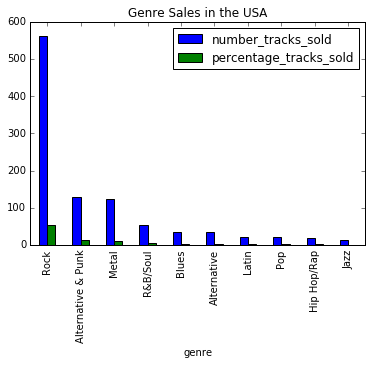

In [7]:
# save query in dataframe
sales_by_genre = run_query(q)

# Create a plot to show this data.
sales_by_genre.set_index('genre',drop=True,inplace=True)
sales_by_genre.plot(kind='bar', title='Genre Sales in the USA')

From the query and graph above, it appears that Rock, Alternative & Punk, and Metal are the highest sold genres for Chinook. The lowest sold genres are Jazz, Hip-Hop, and Pop. From the data, I would recommend that we should purchase the albums from Red Time, a punk artist, Slim Jim Bites, a Blues artist, and Meteor and the Girls, a pop artist. These artists' genres sell the most among the group of four options.

Alternatively, I would suggest that the record label should negotiate to find artists that are more suited to the tastes of their customers. The market is dominated by Rock, which represents over 50% of sales. Along with the next two most popular genres Alternative & Punk and Metal, these three genres cover over three-quarters of sales. Therefore, it's a better business decision for Chinook increase sales with a revised deal that promotes Rock, Punk, Metal, and Alternative artists.

### Analyzing Employee Sales Performance
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

**Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.**

In [75]:
q = """
    WITH invoices_per_agent AS 
        (
        SELECT e.employee_id AS employee_id,
               e.first_name || " " || e.last_name AS employee_name,
               e.hire_date AS hire_date,
               i.invoice_id
        FROM employee e
        INNER JOIN customer c ON e.employee_id = c.support_rep_id
        INNER JOIN invoice i on i.customer_id = c.customer_id
        ),

        revenue_per_invoice AS
        (
        SELECT i.invoice_id AS invoice_id,
               SUM(il.unit_price * il.quantity) AS invoice_revenue,
               SUM(il.quantity) AS units_sold
        FROM invoice i
        INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
        GROUP BY i.invoice_id
        ),
        
        supervisor AS
        (
        SELECT e1.employee_id AS employee_id,
              e2.first_name || " " || e2.last_name AS supervisor_name
        FROM employee e1
        INNER JOIN employee e2 ON e1.employee_id = e2.reports_to
        )

        SELECT ipa.employee_name AS employee_name,
               ipa.hire_date AS hire_date,
               s.supervisor_name AS supervisor_name,
               SUM(rpi.invoice_revenue) AS total_revenue,
               SUM(rpi.units_sold) AS total_units_sold
        FROM invoices_per_agent ipa
        INNER JOIN revenue_per_invoice rpi ON ipa.invoice_id = rpi.invoice_id
        LEFT JOIN supervisor s ON ipa.employee_id = s.employee_id
        GROUP BY employee_name
        ORDER BY invoice_revenue DESC    
    """
run_query(q)

,employee_name,hire_date,supervisor_name,total_revenue,total_units_sold
0,Jane Peacock,2017-04-01 00:00:00,None,1731.51,1749
1,Margaret Park,2017-05-03 00:00:00,None,1584.00,1600
2,Steve Johnson,2017-10-17 00:00:00,None,1393.92,1408


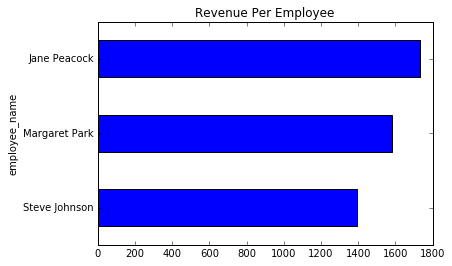

In [77]:
# save query in dataframe
employee_sales = run_query(q)

# Create a plot to show this data.
employee_sales.set_index('employee_name', drop=True, inplace=True)
employee_sales.sort_values('total_revenue', inplace=True)
employee_sales[['total_revenue']].plot.barh(title='Revenue Per Employee', legend=None)

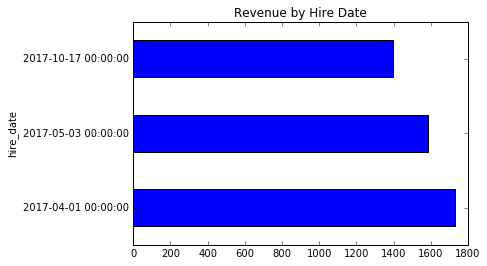

In [82]:
employee_sales = run_query(q)
#convert dates to datetime objects
pd.to_datetime(employee_sales['hire_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
employee_sales.set_index('hire_date', drop=True, inplace=True)
employee_sales[['total_revenue']].plot(title='Revenue by Hire Date', legend=None, kind='barh')

In [109]:
# calculate percent changes between employees
employee_sales = run_query(q)
employee_sales.set_index('employee_name', drop=True, inplace=True)
peacock_rev = employee_sales.loc['Jane Peacock']['total_revenue']
park_rev = employee_sales.loc['Margaret Park']['total_revenue']
johnson_rev = employee_sales.loc['Steve Johnson']['total_revenue']

peacock_johnson = ((peacock_rev-johnson_rev)/peacock_rev)*100
peacock_park = ((peacock_rev-park_rev)/peacock_rev)*100

print('Peacock has outsold Park by ' + str(round(peacock_park, 2)) + '%.')
print('Peacock has outsold Johnson by ' + str(round(peacock_johnson,2)) + '%.')

Peacock has outsold Park by 8.52%.
Peacock has outsold Johnson by 19.5%.


From the analysis of employee sales performance, Jane Peacock is has the made the most sales in terms of units sold and total revenue, while Steve Johnson has performed at the bottom. In terms of revenue, Jane Peacock has outperformed Margaret Park by 8.52% and Steve Johnson by 19.5%.

One of the least influential factors is the employee's supervisor, since none of them have managers.

However, one of the most influential factors into Peacock's success may be that she arrived at the company over six months before Johnson, giving her a head start in making sales. If we knew what month this theoretical dataset was collected, we could measure **sales per month** to get a more comparable metric from which to evaluate employee performance.